# Control-Lyapunov Function for Driving a Wheeled Robot

This notebook implements the controller proposed in "[Closed loop steering of unicycle-like vehicles via Lyapunov techniques](https://ieeexplore.ieee.org/abstract/document/388294)" by M. Aicardi, G. Casalino, A. Bicchi, and A. Balestrino.

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib.  
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [2]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# pydrake imports
from pydrake.all import (VectorSystem, DiagramBuilder, SymbolicVectorSystem, LogOutput,
                         Variable, Simulator, cos, sin)

## Robot Kinematics
We start writing down symbolically the kinematics of the robot.
The vehicle will be then represented as a Drake `SymbolicVectorSystem`.

In [3]:
# state of the robot (in cartesian coordinates)
z1 = Variable("z1") # horizontal position
z2 = Variable("z2") # vertical position
z3 = Variable("z3") # angular position
cartesian_state = [z1, z2, z3]

# control input of the robot
u1 = Variable("u1") # linear velocity
u2 = Variable("u2") # angular velocity
input = [u1, u2]

# nonlinear dynamics, the whole state is measured (output = state)
dynamics = [u1*cos(z3), u1*sin(z3), u2]
robot = SymbolicVectorSystem(
    state=cartesian_state,
    input=input,
    output=cartesian_state,
    dynamics=dynamics,
)

## Write the Control Law
It is time to write the controller.
To do that we construct a `VectorSystem` with a method called `DoCalcVectorOutput`.
In the latter, we write all the steps needed to compute the instantaneous control action from the vehicle state.

In [4]:
# you will write the control law in it in the next cell
# by defining the function called "lyapunov_controller"
class ParkingController(VectorSystem):

    def __init__(self, lyapunov_controller):
        # 3 inputs (robot state)
        # 2 outputs (robot inputs)
        VectorSystem.__init__(self, 3, 2)
        self.lyapunov_controller = lyapunov_controller

    def DoCalcVectorOutput(
            self,
            context,          # not used
            cartesian_state,  # input of the controller
            controller_state, # not used
            input             # output of the controller
        ):
        
        # upack state of the robot
        z1, z2, z3 = cartesian_state
        
        # state in polar coordinates
        x1 = np.sqrt(z1**2 + z2**2) # radial coordinate
        x2 = np.arctan2(z2, z1)     # angular coordinate
        x3 = x2 - z3
        
        # evaluate the function below and return the robot's input
        input[:] = self.lyapunov_controller(x1, x2, x3)

In the following cell, modify the function `lyapunov_controller` to implement the control law from point (b) of the exercise.
The function must return the linear $u_1$ and the angular $u_2$ velocity of the robot.
Currently, it just returns zero input, and the robot does not move.

To simplify your work, the input of this function is the state already expressed in polar coordinates:
- `x1`: radial coordinate,
- `x2`: angular coordinate,
- `x3`: angle between the radial vector and the robot orientation.

**Attention:**
The function $u_2 = \pi_2 (\mathbf x)$ is not defined for $x_3 = 0$.
To prevent divisions by zero, we defined a tolerance of $10^{-3}$ (do not modify this value) and whenever the absolute value of $x_3$ is lower than or equal to this tolerance you should use the Taylor approximation $\cos(x_3)\sin(x_3)/x_3 \approx 1$.

In [5]:
def lyapunov_controller(x1, x2, x3):
    if np.abs(x3) <= 1e-3: # do not modify
        u1 = -x1 * np.cos(x3) # modify here
        u2 = x2 + 2 * x3 # modify here
    else:
        u1 = -x1 * np.cos(x3) # modify here
        u2 = x3 + ((x2+x3)*np.cos(x3)*np.sin(x3))/x3 # modify here
    return u1, u2

## Wire the Block Diagram
Now we connect the controller with the robot.
To this end, we construct a Drake diagram.

In [6]:
# construction site for our closed-loop system
builder = DiagramBuilder()

# add the robot to the diagram
# the method .AddSystem() simply returns a pointer to the system
# we passed as input, so it's ok to give it the same name
robot = builder.AddSystem(robot)

# add the controller
controller = builder.AddSystem(ParkingController(lyapunov_controller))

# wire the controller with the system
builder.Connect(robot.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), robot.get_input_port(0))

# add a logger to the diagram
# this will store the state trajectory
logger = LogOutput(robot.get_output_port(0), builder)

# complete the construction of the diagram
diagram = builder.Build()

## Simulate the Closed-Loop System
It's time to simulate the closed-loop system: just pass the diagram we constructed to the simulator and press play!

In [7]:
# reset logger to delete old trajectories
# this is needed if you want to simulate the system multiple times
logger.reset()

# set up a simulation environment
simulator = Simulator(diagram)

# set the initial cartesian state to a random initial position
# try initial_state = np.random.randn(3) for a random initial state
initial_state = [0, 1, 0] 
context = simulator.get_mutable_context()
context.SetContinuousState(initial_state)

# simulate from zero to sim_time
# the trajectory will be stored in the logger
sim_time = 20.
simulator.AdvanceTo(sim_time)

## Plot the Parking Trajectory
No need to fully inderstand the following lines of code, they are just plotting helpers...
Just get a sense of which parameter to modify in case you want to costumize the plot.

In [8]:
# vehicle size in the plot
length = .5
width = .3

# function that draws a triangle given the cartesian state of the robot
def draw_robot(cartesian_state, **kwargs):
    
    # transformation matrix from global to robot frame
    z1, z2, z3 = cartesian_state
    T = np.array([
        [np.cos(z3), -np.sin(z3), z1],
        [np.sin(z3), np.cos(z3), z2]
    ])

    # compute cartesian coordinates of the corners of the car
    left_back = T.dot([-length/2, width/2, 1])
    right_back = T.dot([-length/2, -width/2, 1])
    front = T.dot([length/2, 0, 1])
    
    # draw a triangle that symbolizes the robot
    robot = patches.Polygon(
        np.vstack([left_back, right_back, front]),
        facecolor='none',
        **kwargs
    )
    plt.gca().add_patch(robot)

# function that draws the trajectory of the robot
# initial and final states are red and blue, respectively
def draw_trajectory(trajectory):

    # draw trajectory of the robot in black
    for state in trajectory.T:
        draw_robot(state, edgecolor='k')
        
    # draw initial configuration of the robot in red
    draw_robot(
        trajectory[:,0],
        edgecolor='r',
        linewidth=3,
        label='Initial configuration'
    )

    # draw final configuration of the robot in blue
    draw_robot(
        trajectory[:,-1],
        edgecolor='b',
        linewidth=3,
        label='Final configuration'
    )

Here is the final plot!

Text(0.5, 1.0, 'Robot parking trajectory')

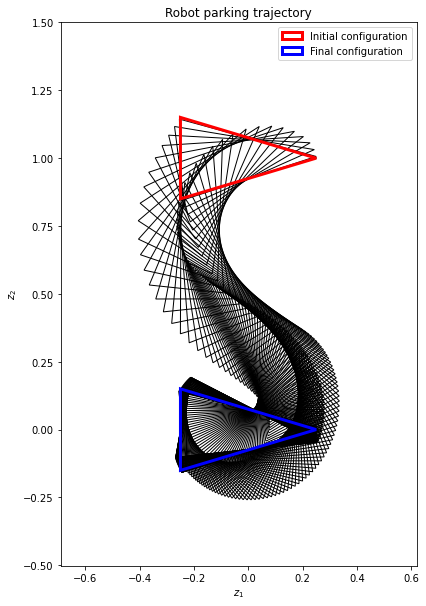

In [9]:
# draw parking trajectory
plt.figure(figsize=(10, 10))
draw_trajectory(logger.data())

# adapt figure limits to the trajectory
robot_size = max(length, width)
plt.xlim([
        min(logger.data()[0,:]) - robot_size,
        max(logger.data()[0,:]) + robot_size
])
plt.ylim([
        min(logger.data()[1,:]) - robot_size,
        max(logger.data()[1,:]) + robot_size
])

# misc plot settings
plt.gca().set_aspect('equal')
plt.legend()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Robot parking trajectory')

## Autograding

You can check your work by running the following cell:

In [10]:
from underactuated.exercises.lyapunov.control.test_control import TestControl
from underactuated.exercises.grader import Grader
Grader.grade_output([TestControl], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 8/8.

Score for Test Lyapunov controller away from origin is 4/4.

Score for Test Lyapunov controller near origin is 4/4.
